In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[1]
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


0,1
1
Thu Dec  7 16:01:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   29C    P0    36W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| 

In [9]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

job_duration = 6
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

# model_name = 'llama-7b'; encode_fn_type = 'sft'; md = 'llama7b'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'llama7b'
# model_name = 'llama-7b+lima+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'llama7b'
# model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'mistral7b'
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; md = 'mpnet'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'; md = 'bge'
# model_name = 'codellama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'codellama7b'


sort_by_list = []

# sort_by_list += [
#     'random_s=0', 'random_s=1', 'random_s=2',
#     'log_prob', 'logit_margin', 'el2n_agg=mean', 'grad_loraB_l2n',
#     'ifd', 'log_pmi',
# ]

# ## wizardlm
# sort_by_list = [
#     'dppmap_k=lin_kmd=mpnet'
# ]
# sort_by_list = ['numtoks']
## dedup smalld datasets
# sort_by_list += [
#     'dedup_md=mpnet_emb=text+embedding'
# ]

# ## starcoder_commentinstrv2 85k->10k
# sort_by_list += [
#     f'dppmap_k=vmf_gamma={gamma}_kmd=mpnet'
#     for gamma in [0.038]
# ]

# # wizardlm 50k
# sort_by_list += [
#     f'dppmap_k=vmf_gamma={gamma}_kmd=mpnet'
#     for gamma in [0.024] # .1, 1., 10.
# ]; job_duration = 6


sort_by_list += [
    f'dppmap_theta={theta}_k=vmf_gamma={gamma}_kmd=mpnet_q={q}_qmd=llama7b'
    for q in ['log+pmi'] # ['ifd', 'ifd+neg'] # 'log+pmi'
    for gamma in [0.01] # [0.042]
    for theta in [.3] # .3, .1, .5, .7
]

# sort_by_list = ['ifd', 'log_pmi']

# sort_by_list += [
#     'dedup_md=mpnet_emb=text+embedding',
# ]

# nc_list = [100, 500, 1000]
# nc_list = [100, 200, 300, 400, 500, 600]
# sort_by_list = [
#     f'semdedup_cl=kmeansfaisscd_md={md}_dist=cd_emb={emb}_nc={nc}'
#     for nc in nc_list
#     for emb in ['text+embedding', 'grad+rp+loraB'] # 'grad+rp+loraB' 
# ]

# dataset_list = ['lima']
# dataset_list = ['flan2022_1m']
# dataset_list = ['tulu_v1_mix']
# dataset_list = ['ultrachat']
# dataset_list = ['ultrachat15']
dataset_list = ['wizardlm']
# dataset_list = ['sharegpt']
# dataset_list = [
#     'starcoder_commentinstr', 
#     'starcoder_commentinstr_cleaned',
#     'starcoder_commentinstrv2',
#     'starcoder_commentinstrv2_flppl',
# ]

# sort_by_list = [
#  'log_prob',
#  'el2n_agg=mean',
#  'el2n_agg=l2n',
#  'logit_margin',
# ]
# if 'lora' in model_name:
#     sort_by_list += ['grad_loraB_l2n']
# else:
#     sort_by_list += ['grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',]
# sort_by_list = ['kmeansl2_emb=grad+rp+loraB_nc=30',
#                 'kmeansl2_emb=text+embedding_nc=30']
# dataset_list = ['lima']


# model_name = 'pythia-1b-deduped'
# model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# dataset_list = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']
# sort_by_list = ['random_s=0', 'random_s=1', 'random_s=2',
#                 'log_prob', 'logit_margin', 'el2n_agg=mean', 
#                 'grad_loraB_l2n',
#                 'grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',
#                ]
# sort_by_list = ['grad_loraB_l2n']

from note_pruning_analysis import data_inds_dir

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    save_dir = os.path.join(data_inds_dir, model_name, dataset)
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --model_name {model_name} \
        --encode_fn_type {encode_fn_type} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=256, # 128
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=job_duration,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


test_run = False

Submiting job with:
{
    "job_name": "prune.wizardlm.dppmap_k=vmf_gamma=0.024_kmd=mpnet",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset wizardlm --sort_by dppmap_k=vmf_gamma=0.024_kmd=mpnet --model_name all-mpnet-base-v2 --encode_fn_type input --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/all-mpnet-base-v2/wizardlm

Submiting job with:
{
    "job_name": "prune.wizardlm.dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset wizardlm --sort_by dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b --model_name all-mpnet-base-v2 --encode_fn_type inp

In [6]:
with open('note_pruning_run_cmds.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [7]:
!bash note_pruning_run_cmds.sh

+ CUDA_VISIBLE_DEVICES=1
+ python note_pruning.py --dataset wizardlm --sort_by dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b --model_name all-mpnet-base-v2 --encode_fn_type input --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/all-mpnet-base-v2/wizardlm
/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')
{
  "dataset": "wizardlm",
  "sort_by": "dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b",
  "model_name": "all-mpnet-base-v2",
  "save_dir": "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/all-mpnet-base-v2/wizardlm",
  "encode_fn_type": "input",
  "test_run": false
}
Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmap",
    "dataset": "wizardlm",
    "kernel_typ

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [10]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
    plt_curriculum,
)
from note_pruning_analysis import assets_dir

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 3
# model_name = 'llama-7b'; dataset = 'sharegpt'; M = 150_000; num_epochs = 3

## mistral+ultrachat
# model_name = 'mistral-7b'; dataset = 'ultrachat200k'; M = 50_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 200_000; num_epochs = 2

## semdedup
# model_name = 'bge-large-en-v1.5'; dataset = 'wizardlm'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2

## starcoder
# M = 25_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstr_cleaned', 'starcoder_commentinstr']
# M = 50_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstrv2']

## wizardlm
# M = 100_000; num_epochs = 2; model_name = ['llama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['wizardlm'] # prune to 50k
# M = 50_000; num_epochs = 5; model_name = ['llama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['wizardlm'] # prune to 10k
M = 10_000; num_epochs = 10; model_name = ['llama-7b', 'all-mpnet-base-v2']; \
    dataset = ['wizardlm'] # prune to 1k



pacing_fn_list = [
#     f'prune_size={M}_ep=1',
    f'prune_size={M}_ep={num_epochs}',
#     f'prune_size={M}_ep=3',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.05',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
]

output_list = generate_curriculum_forall_scoring_fn(
    model_name, dataset, pacing_fn_list, verbose=False)

save inds (length = 10000) to curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=g

save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/ind

save inds (length = 10000) to curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/inds_prune_size=10000_ep=10.pkl


[407049.82438535  -3150.73833417]


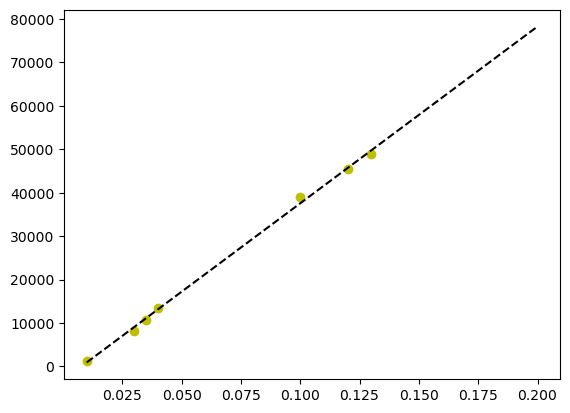

In [16]:
import numpy as np
import matplotlib.pyplot as plt
xs = np.array([0.001, 0.009, 0.01, 0.03, .035, 0.04, 0.1, 0.12, 0.13])[1:]
ys = np.array([687, 1372, 1283, 8216, 10774, 13469, 38997, 45475, 49009])[1:]

coeff = np.polyfit(xs, ys, 1)
print(coeff)
poly1d_fn = np.poly1d(coeff) 

xs_extrap = np.linspace(0.01, 0.2, 100)

plt.plot(xs, ys, 'yo', xs_extrap, poly1d_fn(xs_extrap), '--k')
# plt.xlim(())


In [31]:
poly1d_fn([0.01, 0.03, 0.035, 0.035, 0.06, 0.12])





array([  919.75990968,  9060.75639739, 11096.00551932, 11096.00551932,
       21272.25112895, 45695.24059207])

In [36]:
import pickle

dataset = 'starcoder_commentinstrv2'; gammas = [0.009, 0.01, 0.02, 0.035, 0.038, 0.04]
dataset = 'wizardlm'; gammas = [0.009, 0.01, 0.02, 0.03, 0.04, 0.06, 0.1, 0.12, 0.13]
save_paths = {
    gamma: f'dpp/{dataset}/dppmap_k=vmf_gamma={gamma}_kmd=mpnet/data.pkl'
    for gamma in gammas}

data = {}
for k, path in save_paths.items():
    with open(path, 'rb') as f:
        data[k] = pickle.load(f)
        
save_paths = {
    gamma: f'curriculum/all-mpnet-base-v2/{dataset}/dppmap_k=vmf_gamma={gamma}_kmd=mpnet/scores.pkl'
    for gamma in gammas
}

for k, path in save_paths.items():
    with open(path, 'rb') as f:
        data[k].update(pickle.load(f))

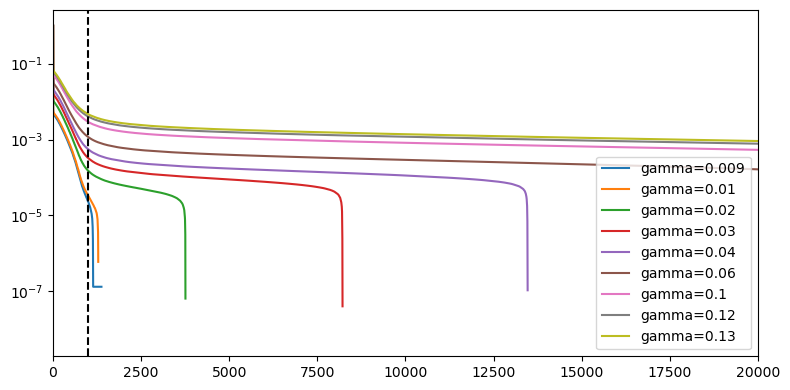

In [37]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(1,1,figsize=(8,4))
for gamma in gammas:
    ax.plot(data[gamma]['marginal_gains'], label=f'gamma={gamma}')
plt.axvline(x=1_000, color='k', linestyle='--')
ax.set_yscale('log')
ax.set_xlim((0, 20_000))
ax.legend()
fig.tight_layout()

In [12]:
get_inds = lambda gamma: \
    [x[0] for x in sorted(list(enumerate(data[gamma]['S'])), key=lambda x: x[1])]

inds1 = get_inds(0.02)
inds2 = get_inds(0.04)

In [30]:
# l1 = get_inds(0.038)
l1 = get_inds(0.035)
l2 = get_inds(0.04)

k = min(len(l1),len(l2))
# k = 70_000
print(k)
len(set(l1[:k])&set(l2[:k]))/k

84998


1.0

In [37]:
list(zip(inds1, inds2))

for k in [50,100,200,1000, 2000, len(data[0.02]['marginal_gains'])]:
    print(k, 
          (np.array(inds1[:k])==np.array(inds2[:k])).sum(),
          len(set(inds1[:k])&set(inds2[:k]))/k
         )

50 45 0.96
100 79 0.97
200 81 0.665
1000 82 0.562
2000 82 0.6995
3275 82 0.7041221374045802


curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/scores.pkl
fixed exponential pacing startingfrac=0.05, inc=20.0, nsteps=2 
Implies: step_lens=[25000, 25000], stepwise_data_fracs=[0.05, 1.0]
fixed exponential pacing startingfrac=0.05, inc=1.5, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.07500000000000001, 0.1125, 0.16875, 0.253125]
fixed exponential pacing startingfrac=0.05, inc=2.0, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.1, 0.2, 0.4, 0.8]


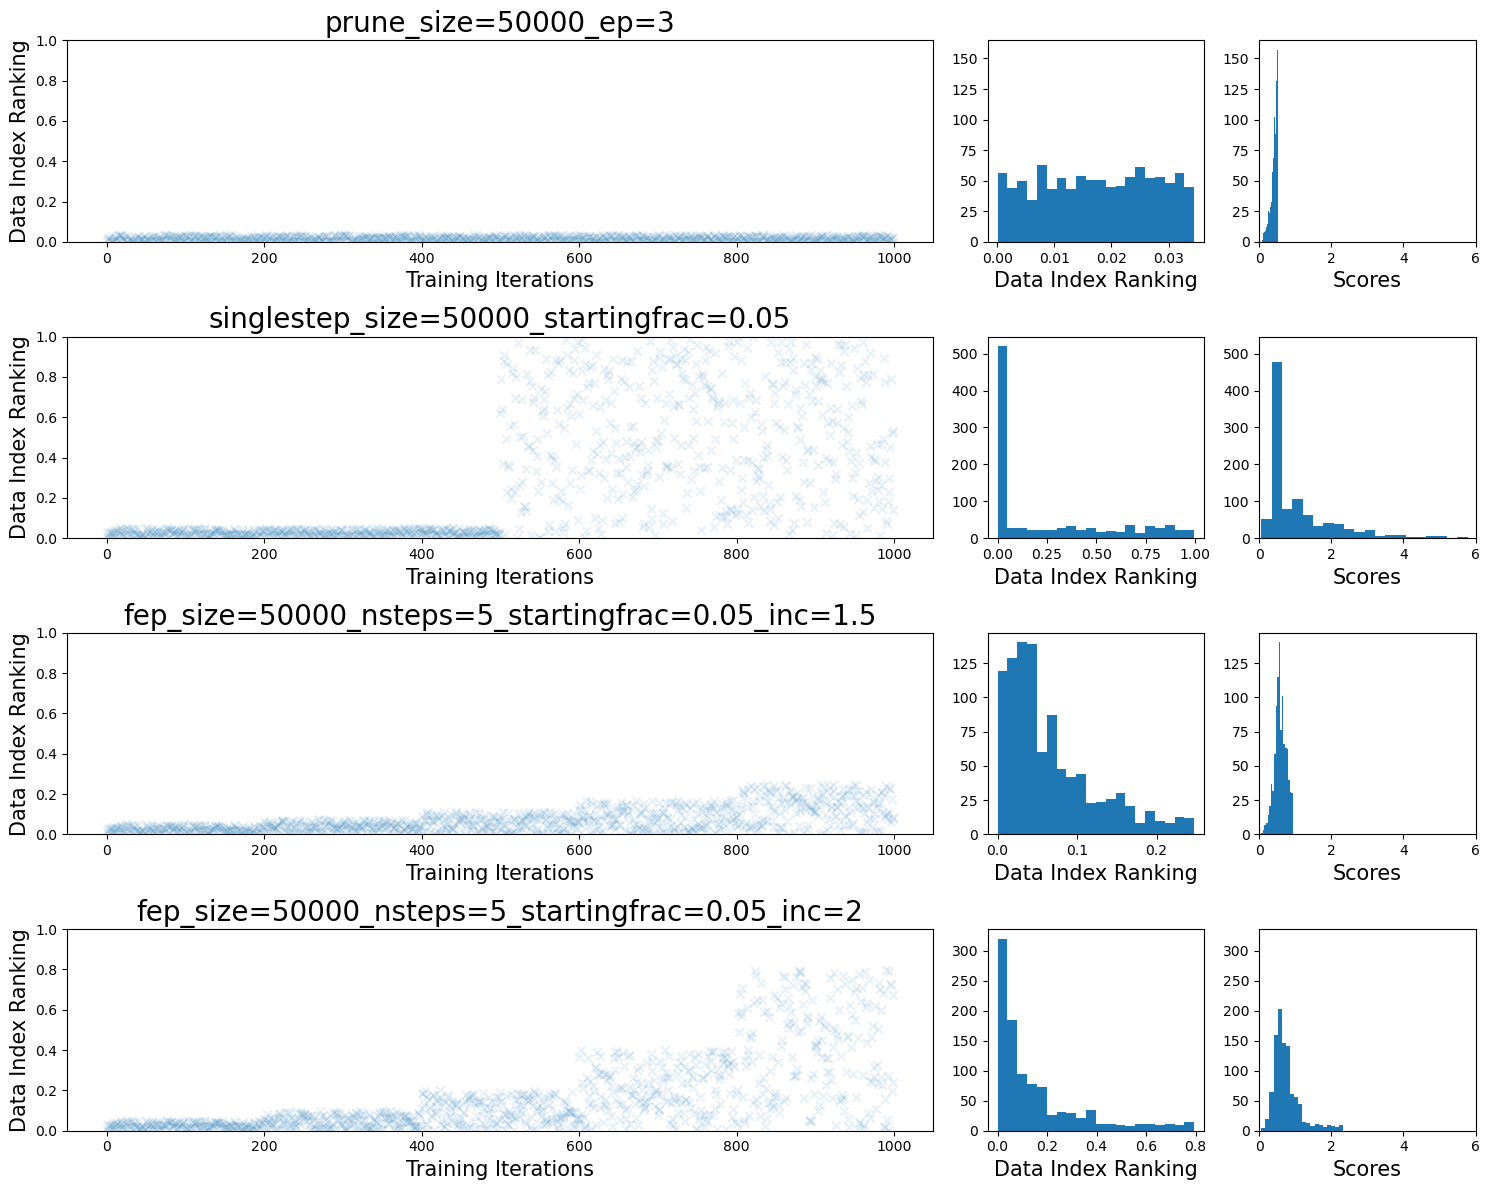

In [4]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores, generate_curriculum, plt_curriculum
import glob
import matplotlib.pyplot as plt

model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000


paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = True
print(path)
pacing_fn = f'prune_size={M}_ep=3'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.2'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.3'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.2_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'

pacing_fn_list = [
    f'prune_size={M}_ep=3',
    f'singlestep_size={M}_startingfrac=0.05',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=3',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.25'
]



nrows = len(pacing_fn_list)
fig, axs = plt.subplots(nrows, 3, figsize=(15,3*nrows), sharey=False, gridspec_kw={'width_ratios': [2,.5,.5]})

for i, pacing_fn in enumerate(pacing_fn_list):

    plt_kwargs = generate_curriculum(path, pacing_fn, verbose=True, save_output=False)
    output = plt_kwargs.pop('output')
    plt_kwargs.update({'fig': fig, 'axs': axs[i]})
    plt_curriculum(**plt_kwargs)

fig.tight_layout()



save_plt = 0
if save_plt:
    model_name, dataset, scoring_fn = output['model_name'], output['dataset'], output['scoring_fn']
    save_path = os.path.join(
        assets_dir, f'note_curriculum_{model_name}:{dataset}:{scoring_fn}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)



### main code

In [14]:
import os
import sys
import numpy as np
import time
import re
import random
import json
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,
    save_prune_results,
    sort_dpp_map_memefficient,
)
from note_pruning_analysis import get_lm_output
from note_pruning_dpp import torch_vmf_kernel, torch_rbf_kernel
from functools import partial

from transformers import AutoTokenizer

from rosemary import parse_kv_from_string, create_string_from_kv
from note_pruning_analysis import lm_output_dir, get_dataset_token_lengths

import note_pruning_dpp
import note_pruning_clustering

In [15]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
# dataset = 'flan2022_1m'
# dataset = 'lima'
# dataset = 'ultrachat200k'
# dataset = 'tulu_v1_mix'
dataset = 'wizardlm'
# dataset = 'ultrachat15'
# dataset = 'starcoder_commentinstr_cleaned'

# sort_by = 'random_s=0'
# sort_by = 'kmeansl2_nc=3000'
# sort_by = 'kmeanscd_nc=3000'
# sort_by = 'log_prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'
# sort_by = 'grad_norm'
# sort_by = 'dppmap_k=lin_kmd=mpnet'
# sort_by = 'kmeansl2_emb=grad+rp+loraB_nc=3000'
# sort_by = 'kmeansl2_emb=text+embedding_nc=3000'
# sort_by = 'dppmap_emb=text+embedding_k=Kcos'
# sort_by = 'logit_margin'
# rhov1: mistral-7b base-tuned(ultrachat200k_beforesplitlongconv)
# sort_by = 'rhov1'
# sort_by = 'numtoks'
# sort_by = 'semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200'
sort_by = 'semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1'

# used for generating model output.
# model_name = 'llama-7b'; encode_fn_type = 'sft'
# model_name = 'llama-7b_ft=hmv1'; encode_fn_type = 'sft'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
# model_name = 'llama-7b+lima+lora:r=256:a=256'; encode_fn_type = 'sft'
# model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'
# model_name = 'codellama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'

# model_name = 'mistral-7b+lora:r=256:a=256__rho__mistral-7b-ultrachat200k-v1+lora:r=256:a=256'


save_dir = f"data_inds/"
save_dir = os.path.join(save_dir, '' if encode_fn_type=='sft' else encode_fn_type, model_name, dataset)
os.makedirs(save_dir, exist_ok=True) 

print(dataset, model_name, sort_by)
print(save_dir)

wizardlm all-mpnet-base-v2 semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1
data_inds/input/all-mpnet-base-v2/wizardlm


In [16]:
d = get_lm_output(dataset, model_name, encode_fn_type=encode_fn_type, return_text_embedding=True)
if test_run:
    d = {k: v[:1000] for k, v in d.items()}
    
# some entries are nan, impute with mean value.
N = d['text_embedding'].shape[0]
print(N)

143000


In [17]:
d['text_embedding'].shape

(143000, 768)

In [20]:
sort_by = 'dppmap_k=lin_gamma=-2_kmd=mpnet'
# sort_by = 'dppmap_k=vmf_gamma=.1_kmd=mpnet'


kvs = parse_kv_from_string(sort_by)
if kvs['k'] == 'vmf':
    kernel_kwargs = {'gamma': kvs['gamma']}
elif kvs['k'] == 'rbf':
    kernel_kwargs = {'sigma': kvs['sigma']}
elif kvs['k'] == 'lin':
    kernel_kwargs = {'gamma': kvs['gamma']}
else:
    kernel_kwargs = {}
kwargs = {
    'dppmap_type': 'dppmap',
    'dataset': dataset,
    'kernel_type': kvs['k'],
    'kernel_embed_model': kvs['kmd'],
    'kernel_embed_type': re.sub(r'[+]', '_', kvs['kemb']) if 'kemb' in kvs else 'text_embedding',
    'kernel_kwargs': kernel_kwargs,
    'quality_score_type': re.sub(r'[+]', '_', kvs['q']) if 'q' in kvs else None,
    'quality_score_embed_model': kvs.get('qmd', None),
    'theta': kvs.get('theta', 0.), # defaults to just diversity no quality
    'device': 'cuda',
    'max_length': min(20_000, N), # balance finish job within 6 hrs with wanting to prune a lot. meaning resulting scores will only be valid up to 20k for large datasets.
    'run_name': sort_by,
}
print(f'Calling note_pruning_dpp.compute_dppmap with kwargs={json.dumps(kwargs, indent=4)}')
S, output = note_pruning_dpp.compute_dppmap(**kwargs)

Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmap",
    "dataset": "wizardlm",
    "kernel_type": "lin",
    "kernel_embed_model": "mpnet",
    "kernel_embed_type": "text_embedding",
    "kernel_kwargs": {
        "gamma": -2
    },
    "quality_score_type": null,
    "quality_score_embed_model": null,
    "theta": 0.0,
    "device": "cuda",
    "max_length": 20000,
    "run_name": "dppmap_k=lin_gamma=-2_kmd=mpnet"
}


  1%|▏         | 263/19999 [00:05<06:55, 47.55it/s, di^2: =nan]

KeyboardInterrupt



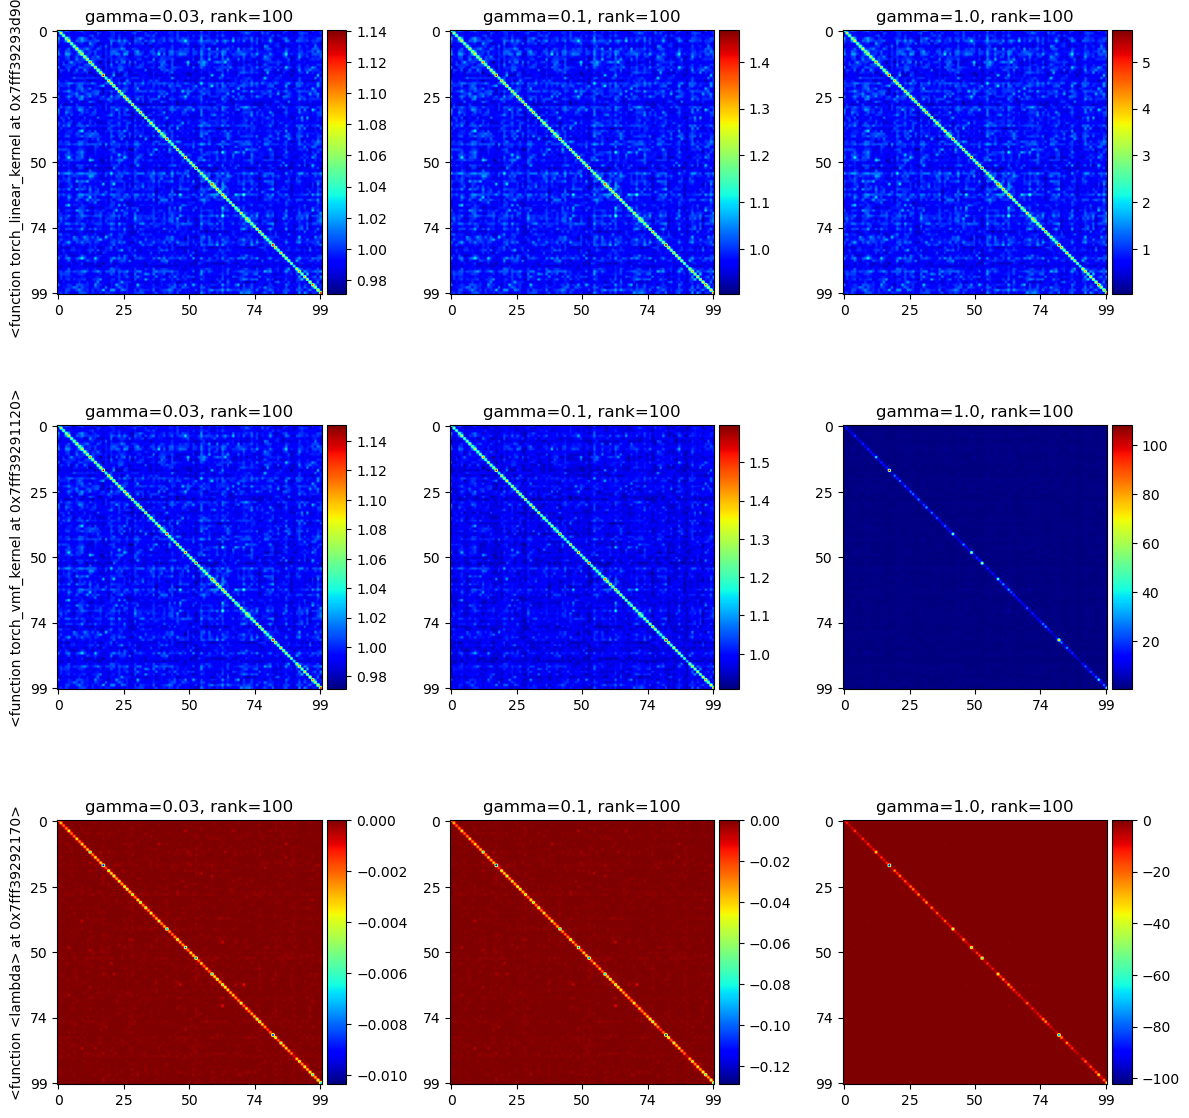

In [21]:
from functools import partial
import matplotlib.pyplot as plt
X = torch.from_numpy(d['text_embedding'][:100])


def torch_linear_kernel(X, Y, gamma=1.0):
    """ linear kernel k(x,y)=γ·(x^Ty+1)/2. """
    S = X@Y.T
    S = (S-1)/2
    K = gamma*S + 1
    return K


def torch_vmf_kernel(X, Y, gamma=1.0):
    """Computes exponentiated inner product kernel k(x,y)=exp(γ·x^Ty)"""
    S = X@Y.T
    S = (S-1)/2 # ensures S \in [-1,0]
    K = torch.exp(gamma*S) # ensures K \in [0,1]
    return K


lin_minus_vmf = lambda X, Y, gamma: torch_linear_kernel(X, Y, gamma) - torch_vmf_kernel(X, Y, gamma)


from rosemary import plt_kernel_matrix_one


# kernel_fns = {
#     'lin_gamma=0.1': partial(torch_linear_kernel, gamma=0.1),
#     'lin_gamma=1.': partial(torch_linear_kernel, gamma=1.),
#     'vmf_gamma=0.1': partial(torch_vmf_kernel, gamma=0.1),
#     'vmf_gamma=1.': partial(torch_vmf_kernel, gamma=1.),
# }
gammas = [0.03, 0.1, 1.]

fig, axs = plt.subplots(3, 3,figsize=(12,12))
for axj, gamma in enumerate(gammas):
    for axi, kernel_fn in enumerate([torch_linear_kernel, torch_vmf_kernel, lin_minus_vmf]):
        ax = axs[axi, axj]
        K = kernel_fn(X, X, gamma=gamma)
        r = torch.linalg.matrix_rank(K)
        plt_kernel_matrix_one(fig, ax, K)
        ax.set_title(f'gamma={gamma}, rank={r}')
        if axj == 0:
            ax.set_ylabel(kernel_fn)
fig.tight_layout()

In [ ]:
# K = gamma*S + 1
# gamma=1.0: 1031
# gamma=0.1: 1027
# gamma=0.01: 783

In [14]:
## the copy in `note_pruning.py` is most up to date

pkl_extra = {}
inds = None

# sort_by = 'log_prob'
# sort_by = 'dppmapbd_nc=200_k=lin_kmd=mpnet'

# sort_by = 'dppmap_nc=200_k=vmf_gamma=0.3_kmd=mpnet'
# sort_by = 'dppmap_nc=200_k=vmf_gamma=1.0_kmd=mpnet'
# sort_by = 'dppmap_nc=200_k=vmf_gamma=3.0_kmd=mpnet'
# sort_by = 'dppmapbd_nc=200_theta=.5_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b'
# sort_by = 'dppmapbd_nc=200_theta=.3_k=vmf_gamma=3.0_kmd=mpnet_q=ifd_qmd=llama7b+lima'
# sort_by = 'dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet'

# sort_by = 'ifd'
# sort_by = 'dppmap_k=lin_kmd=mpnet'
sort_by = 'dppmap_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b'

# model_name = 'llama-7b+lima+lora:r=256:a=256'; encode_fn_type = 'sft'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'

# sort_by = 'semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200'


t0 = time.time()
if any(sort_by.startswith(x) for x in [
        'log_prob', 
        'el2n',  # el2n_agg={l2n|mean}
        'logit_margin', 
        'grad',  # grad_{loraB|qkv|all|last}_l2n
    ]):
    if sort_by not in d:
        print(f'sort_by={sort_by} not in model output: ({dataset}, {model_name})')
    S = np.nan_to_num(d[sort_by], nan=np.nanmean(d[sort_by])).squeeze()
elif sort_by.startswith('ifd'):
    print(f'encode_fn_type={encode_fn_type} not used! since sort_by={sort_by}')
    S = note_pruning_dpp.get_ifd_and_pmi(dataset, model_name)['ifd']
elif sort_by.startswith('log_pmi'):
    print(f'encode_fn_type={encode_fn_type} not used! since sort_by={sort_by}')
    S = note_pruning_dpp.get_ifd_and_pmi(dataset, model_name)['log_pmi']
elif sort_by.startswith('random'):
    match = re.search(r's=(\d+)', sort_by)
    seed = int(match.group(1))
    np.random.seed(seed)
    S = np.random.rand(N)
    assert(S.shape == np.unique(S).shape)
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'nc=(\d+)', sort_by)
    n_clusters = int(match.group(1)) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
    S, kms = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)
    pkl_extra['kmeans'] = kms
elif sort_by.startswith('semdedup'):
    kvs = parse_kv_from_string(sort_by)
    md = kvs['md']
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
        (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
        (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
        (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')) or \
        (md == 'codellama7b' and not model_name.lower().startswith('codellama-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    clustering_fn = create_string_from_kv(
        {k: v for k, v in kvs.items() if k in ['cl', 'nc', 'bsz', 'ms', 'emb']})
    dist = kvs['dist']
    assert(dist in ['cd', 'l2'])
    embed_type = re.sub(r'[+]', '_', kvs['emb'])
    save_dir_clustering = os.path.join('clustering', encode_fn_type, model_name, dataset, clustering_fn)
    os.makedirs(save_dir_clustering, exist_ok=True)
    # normalize embeddings to unit norm if the model that generated the embeddings does the 
    # same, e.g., mpnet, bge, or if using spherical kmeans clustering.
    if any(x in model_name for x in ['mpnet', 'bge']) or 'kmeansfaisscd' in clustering_fn:
        normalize_embeddings = True
    else:
        normalize_embeddings = False
    kwargs = {
        'model_name': model_name,
        'dataset': dataset,
        'encode_fn_type': encode_fn_type,
        'clustering_fn': clustering_fn,
        'embed_type': embed_type,
        'normalize_embeddings': normalize_embeddings,
        'first_N': None,
        'save_dir': save_dir_clustering,
    }
    print(f'Calling note_pruning_clustering.main with kwargs={json.dumps(kwargs, indent=4)}')
    X, Y, C = note_pruning_clustering.main(**kwargs)
    print('Apply SemDeDup to discard duplicates.')
    S = note_pruning_clustering.semdedup(X, Y, dist=dist, device='cuda')
elif sort_by.startswith('dedup'):
    kvs = parse_kv_from_string(sort_by)
    md = kvs['md']
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
        (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
        (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
        (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')) or \
        (md == 'codellama7b' and not model_name.lower().startswith('codellama-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    if md in ['mpnet', 'bge']:
        normalize_embeddings = True
        dist = 'cd'
    else:
        normalize_embeddings = False
        dist = 'l2'
    embed_type = re.sub(r'[+]', '_', kvs['emb'])
    X = d[embed_type]
    Y = np.zeros(X.shape[0])
    S = semdedup(X, Y, dist=dist, device='cpu')
elif sort_by.startswith('dpp_'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    emb = d[embed_type]
    log_prob = d['log_prob']
    inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)
elif sort_by.startswith('dppmap_'):
    kvs = parse_kv_from_string(sort_by)
    if kvs['k'] == 'vmf':
        kernel_kwargs = {'gamma': kvs['gamma']}
    elif kvs['k'] == 'rbf':
        kernel_kwargs = {'sigma': kvs['sigma']}
    elif kvs['k'] == 'lin':
        kernel_kwargs = {'gamma': kvs.get('gamma', 1.)}
    else:
        kernel_kwargs = {}
    kwargs = {
        'dppmap_type': 'dppmap',
        'dataset': dataset,
        'kernel_type': kvs['k'],
        'kernel_embed_model': kvs['kmd'],
        'kernel_embed_type': re.sub(r'[+]', '_', kvs['kemb']) if 'kemb' in kvs else 'text_embedding',
        'kernel_kwargs': kernel_kwargs,
        'quality_score_type': re.sub(r'[+]', '_', kvs['q']) if 'q' in kvs else None,
        'quality_score_embed_model': kvs.get('qmd', None),
        'theta': kvs.get('theta', 0.), # defaults to just diversity no quality
        'device': 'cuda',
        'max_length': min(55_000, N), # balance finish job within 6 hrs with wanting to prune a lot. meaning resulting scores will only be valid up to 20k for large datasets.
        'run_name': sort_by,
    }
    print(f'Calling note_pruning_dpp.compute_dppmap with kwargs={json.dumps(kwargs, indent=4)}')
    S, output = note_pruning_dpp.compute_dppmap(**kwargs)
elif sort_by.startswith('dppmapbd'):
    kvs = parse_kv_from_string(sort_by)
    md = kvs['kmd']
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
        (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
        (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
        (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    if kvs['k'] == 'vmf':
        kernel_kwargs = {'gamma': kvs['gamma']}
    elif kvs['k'] == 'rbf':
        kernel_kwargs = {'sigma': kvs['sigma']}
    elif kvs['k'] == 'lin':
        kernel_kwargs = {'gamma': kvs.get('gamma', 1.)}
    else:
        kernel_kwargs = {}
    kwargs = {
        'dppmap_type': 'dppmapbd',
        'dataset': dataset,
        'kernel_type': kvs['k'],
        'kernel_embed_model': kvs['kmd'],
        'kernel_embed_type': re.sub(r'[+]', '_', kvs['kemb']) if 'kemb' in kvs else 'text_embedding',
        'kernel_kwargs': kernel_kwargs,
        'quality_score_type': re.sub(r'[+]', '_', kvs['q']) if 'q' in kvs else None,
        'quality_score_embed_model': kvs.get('qmd', None),
        'theta': kvs.get('theta', 0.), # defaults to just diversity no quality
        'device': 'cuda',
        'max_length': 5_000, # per-cluster max length. 
        'run_name': sort_by,
    }
    clustering_fn = create_string_from_kv({
        'cl': kvs.get('cl', 'kmeansfaisscd'),
        'md': kwargs['kernel_embed_model'],
        'emb': kvs['kemb'] if 'kemb' in kvs else 'text+embedding',
        'nc': kvs['nc'],
    })
    save_dir_clustering = os.path.join(
        'clustering', encode_fn_type, model_name, dataset, clustering_fn)
    os.makedirs(save_dir_clustering, exist_ok=True)
    clustering_data_path = os.path.join(save_dir_clustering, 'data.pkl')
    if not os.path.isfile(clustering_data_path):
        normalize_embeddings = True if \
            (any(x in model_name for x in ['mpnet', 'bge']) or 'kmeansfaisscd' in clustering_fn) else False
        kwargs_clustering = {
            'model_name': model_name,
            'dataset': dataset,
            'encode_fn_type': encode_fn_type,
            'clustering_fn': clustering_fn,
            'embed_type': kwargs['kernel_embed_type'],
            'normalize_embeddings': normalize_embeddings,
            'first_N': None,
            'save_dir': save_dir_clustering,
        }
        print(f'Calling note_pruning_clustering.main with kwargs={json.dumps(kwargs_clustering, indent=4)}')
        X, Y, C = note_pruning_clustering.main(**kwargs_clustering)
    else:
        with open(clustering_data_path, 'rb') as f:
            data = pickle.load(f)
        Y = data['Y']
    print(f'Calling note_pruning_dpp.compute_dppmap with kwargs={json.dumps(kwargs, indent=4)}')
    kwargs.update({'Y': Y})
    S, output = note_pruning_dpp.compute_dppmap(**kwargs)
elif sort_by.startswith('rho'):
    if sort_by == 'rhov1':
        model_names = ['mistral-7b+lora:r=256:a=256',
                       'mistral-7b-ultrachat200k-v1+lora:r=256:a=256']
        assert(model_name == model_names[0])
    else:
        raise ValueError(f'sort_by={sort_by} not implemented.')
    assert(len(model_names) == 2)
    ds = []
    for x in model_names:
        ds.append(get_lm_output(dataset, x, return_text_embedding=False, fill_nan=False))
    ks = [set(d.keys()) for d in ds]
    ks = ks[0] & ks[1]
    for k in ks:
        S0 = ds[0][k]
        S1 = ds[1][k]
        # handle nan entries properly.
        nan_mask = np.logical_or(np.isnan(S0), np.isnan(S1))
        S = np.subtract(S0, S1)
        S[nan_mask] = np.nan
        S = S.squeeze()
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)
elif sort_by.startswith('numtoks'):
    if model_name.lower().startswith('llama'):
        tokenizer = AutoTokenizer.from_pretrained('results/baselines/huggyllama/llama-7b', use_fast=False)
    elif model_name.lower().startswith('codellama'):
        tokenizer = AutoTokenizer.from_pretrained('results/baselines/codellama/CodeLlama-7b-hf')
    elif model_name.lower().startswith('mistral'):
        tokenizer = AutoTokenizer.from_pretrained('results/baselines/mistralai/Mistral-7B-v0.1', use_fast=False)
    else:
        raise ValueError('Need to supply appropriate tokenizer to count token lengths,')
    d = get_dataset_token_lengths(dataset, tokenizer)

    d['total_len'] = d['input_len'] + d['output_len']
    for k in ['input', 'output', 'total']:
        S = d[f'{k}_len']
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)

        
t1 = time.time()
print(f'Rank datapoints with {sort_by} took {t1-t0:.2f} seconds.')


Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmap",
    "dataset": "wizardlm",
    "kernel_type": "vmf",
    "kernel_embed_model": "mpnet",
    "kernel_embed_type": "text_embedding",
    "kernel_kwargs": {
        "gamma": 0.035
    },
    "quality_score_type": "log_pmi",
    "quality_score_embed_model": "llama7b",
    "theta": 0.0,
    "device": "cuda",
    "max_length": 20000,
    "run_name": "dppmap_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b"
}


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Loading cached processed dataset at /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-4aae7d7d0cb443eb_*_of_00008.arrow

KeyboardInterrupt



In [13]:

# from note_pruning import save_prune_results
if not any(sort_by.startswith(x) for x in ['rho', 'numtoks']):
    save_prune_results(save_dir, inds, S, pkl_extra, sort_by, model_name, dataset)

save inds (length = 8380) to data_inds/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_incr.pkl
save inds (length = 8380) to data_inds/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_decr.pkl


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-1c0d5cd9d22521b9/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_beg_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_end_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_partition=1:10_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_partition=10:10_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_partition=2:3_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-1c0d5cd9d22521b9/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_random_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_beg_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_end_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_partition=1:10_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_partition=10:10_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_partition=2:3_num=400.txt completed!


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Writing 400 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_random_num=400.txt completed!


In [12]:
save_dir

'data_inds/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned'

In [11]:
s = 'def AdvectionRK4(particle, fieldset, time):\n(u1, v1) = fieldset.UV[particle]\n(lon1, lat1) = (particle.lon + u1 * 0.5 * particle.dt, particle.lat + v1 * 0.5 * particle.dt)\n(u2, v2) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat1, lon1, particle]\n(lon2, lat2) = (particle.lon + u2 * 0.5 * particle.dt, particle.lat + v2 * 0.5 * particle.dt)\n(u3, v3) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat2, lon2, particle]\n(lon3, lat3) = (particle.lon + u3 * particle.dt, particle.lat + v3 * particle.dt)\n(u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]\nparticle.lon += (u1 + 2 * u2 + 2 * u3 + u4) / 6.0 * particle.dt\nparticle.lat += (v1 + 2 * v2 + 2 * v3 + v4) / 6.0 * particle.dt'
print(s)

def AdvectionRK4(particle, fieldset, time):
(u1, v1) = fieldset.UV[particle]
(lon1, lat1) = (particle.lon + u1 * 0.5 * particle.dt, particle.lat + v1 * 0.5 * particle.dt)
(u2, v2) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat1, lon1, particle]
(lon2, lat2) = (particle.lon + u2 * 0.5 * particle.dt, particle.lat + v2 * 0.5 * particle.dt)
(u3, v3) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat2, lon2, particle]
(lon3, lat3) = (particle.lon + u3 * particle.dt, particle.lat + v3 * particle.dt)
(u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]
particle.lon += (u1 + 2 * u2 + 2 * u3 + u4) / 6.0 * particle.dt
particle.lat += (v1 + 2 * v2 + 2 * v3 + v4) / 6.0 * particle.dt
